## Fine-tuning Large Language Models for Audience Classification of Central Bank Speeches
[![Portfolio](https://img.shields.io/badge/Moritz_Pfeifer-CentralBankBERTa-blue?logo=GitHub)](https://github.com/Moritz-Pfeifer/CentralBankBERTa)

# A - Introduction

We split the economic agent dataset of 15,060 sentences into 80% (12,048) train-ing and 20% (3,012) validation data. For this classifier, we focus on RoBERTa with BERT and XLNet (Yang et al., 2019) as baseline comparisons. These LLMs are trained to assign each sentence from our dataset to one of five economic groups: Households, Firms, Financial Sector, Government and Central Bank. We fine-tune these models by testing parameters for batch size, learning rate (LR) and epochs.

# B - Setup

## 1. Load Essential Libraries

In [ ]:
import os
import re
import csv
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2. Upload Datasets

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

Mounted at /content/drive


In [ ]:
import os
path = os.getcwd()+'/drive/MyDrive/CentralBankBERTa/Audience_classification'
path

'/content/drive/MyDrive/CentralBankBERTa/Audience_classification'

The training data consists of manually prelabelled speeches on the sentence level from the Federal Reserve Bank, the European Central Bank and the BIS database.

### 2.1. FED
The FED train dataset is a dataset of prelabelled sentences classified by macrogroup. The dataset contains 6205 sentences from a randomized dataset of FED speeches from 1948-2022.

In [ ]:
data_train_FED = pd.read_csv(path+'/data_input/FED_prelabelled.csv', lineterminator='\n')
data_train_FED.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6205 entries, 0 to 6204
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Parsed_Text  6205 non-null   object
 1   label        6205 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 97.1+ KB


### 2.2. ECB
The ECB train dataset is a dataset of pseudo-labels that were self-trained on the FED training model with an aggregated threshold of 77%. The dataset contains 4051 additional sentences.

In [ ]:
data_train_ECB = pd.read_csv(path+'/data_input/ECB_prelabelled.csv', index_col=0)
data_train_ECB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4051 entries, 0 to 4050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Parsed_Text  4051 non-null   object
 1   label        4051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 94.9+ KB


### 2.3. BIS
The BIS train dataset is a dataset of pseudo-labels that were self-trained on the FED training model with an aggregated threshold of 79%. The dataset contains 4804 additional sentences.

In [ ]:
data_train_BIS = pd.read_csv(path+'/data_input/BIS_prelabelled.csv', index_col=0)
data_train_BIS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4804 entries, 0 to 4803
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Parsed_Text  4804 non-null   object
 1   label        4804 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 112.6+ KB


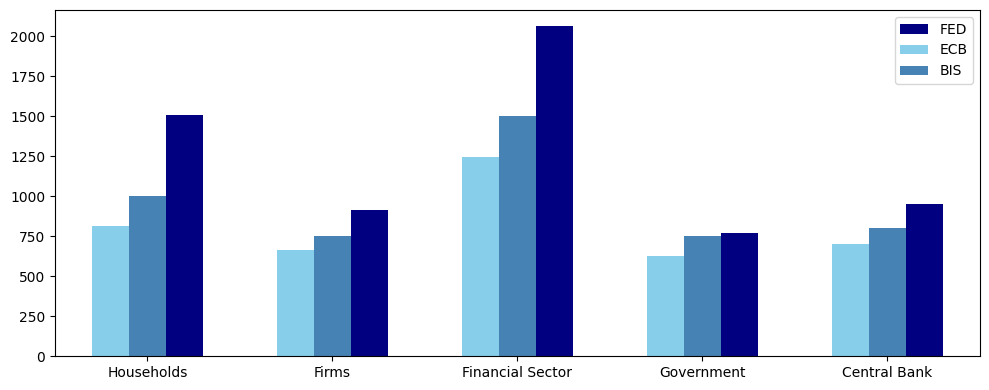

In [ ]:
plt.figure(figsize=(10, 4))
width = .2
audiences = ('Households', 'Firms', 'Financial Sector', 'Government', 'Central Bank')
ax1 = data_train_FED['label'].value_counts().sort_index().plot(kind='bar', color='navy', position=-.5, width = width, label="FED")
ax2 = data_train_ECB['label'].value_counts().sort_index().plot(kind='bar', color='skyblue', position=1.5, width = width, label='ECB')
ax3 = data_train_BIS['label'].value_counts().sort_index().plot(kind='bar', color='steelblue', position=0.5, width = width, label='BIS')
plt.xticks(range(0,5), audiences, rotation = 0)
plt.xlim((-0.5, 4.5))
plt.legend()
plt.tight_layout();


In [ ]:
# Concatenante training data
data_train = pd.concat([data_train_ECB, data_train_FED, data_train_BIS])

In [ ]:
data_train.label.value_counts().sum()

15060

## 2.2. Seperate Dataset into Training and Test Data

The training data set is split into two sets: a train set with 80% of the data and a validation set with 20% of the data.

In [ ]:
from sklearn.model_selection import train_test_split

# Set complete_data to True, if you don't want to split data

complete_data = False

X = data_train.Parsed_Text.values
y = data_train.label.values

if complete_data is False:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print('Data is split into 80% train and 20% validation sets.')
else:
    X_train, X_val, y_train, y_val = X, X, y, y
    print('Data is not split.')

lengthXtrain = len(X_train)
lengthXval = len(X_val)
print('There are ' + str(lengthXtrain) + ' training labels')
print('There are ' + str(lengthXval) + ' validation labels')

Data is split into 80% train and 20% validation sets.
There are 12048 training labels
There are 3012 validation labels


## 4. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


# C - Fine-tuning Large Language Models

## 1. Install the Hugging Face Library

Hugging Face's transformer library includes pre-trained model weights and PyTorch implementations of cutting-edge NLP models like BERT (from Google) and GPT (from OpenAI).

In [ ]:
#Stable version
!pip install transformers==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 69.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=29cb4727246447351803b9889fa7a60c97d718ef9c5210e4d4103645005799e5
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses


In [ ]:
# Required for XLNnet transformer model
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.8 MB/s eta 0:00:00


## 2. Fine Tuning the Models

The model predicts five possible classification values for each input sentence:

> 0: 'p' for Households <br>
> 1: 'f' for Firms <br>
> 2: 'b' for the Financial Sector<br>
> 3: 'g' for the Government <br>
> 4: 'cb' for the Central Banks themselves


We will fine-tune the following large language models and compare the results on our dataset:

> 1) BERT<br>
> 2) XLNet <br>
> 3) RoBERTa <br>

In [ ]:
from scipy.special import softmax

def test_model(model, tokenizer, X_test, y_test):
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)
    test_dataset = AudienceDataset(test_encodings, y_test)

    # Set up the data collator to avoid padding the labels
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set up the trainer with the test data
    trainer = Trainer(model=model, data_collator=data_collator)

    # Make predictions on the test set
    predictions = trainer.predict(test_dataset=test_dataset).predictions.argmax(axis=1)

    # Make predictions on the test set
    predictions_prob = trainer.predict(test_dataset=test_dataset).predictions

    # Return the true and predicted labels
    return y_test, predictions, predictions_prob

In [ ]:
from scipy.special import softmax

def predict_audience(model, tokenizer, X_test):
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)
    y_test = [1] * len(list(X_test))
    test_dataset = AudienceDataset(test_encodings, y_test)

    # Set up the data collator to avoid padding the labels
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set up the trainer with the test data
    trainer = Trainer(model=model, data_collator=data_collator)

    # Make predictions on the test set
    predictions = trainer.predict(test_dataset=test_dataset).predictions.argmax(axis=1)

    # Make predictions on the test set
    predictions_prob = trainer.predict(test_dataset=test_dataset).predictions

    # Return the true and predicted labels
    return predictions, predictions_prob

### 2.1. Hyperparameters & Learning Rate Scheduler


In order to achieve optimal resultas, we can change the hyper-parameters, e.g.:

- Batch size: 8, 16, 32 etc.
- Learning rate: 3e-5, 2e-5, 1e-6, etc.
- Number of epochs: 2, 3, 4, etc.

In [ ]:
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments
from transformers import default_data_collator
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import roc_curve, roc_auc_score


# Create a Dataset object from the encodings
class AudienceDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(18,5))
    plt.subplot(132)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def show_evaluation_results(y_true, y_pred, y_pred_proba, val_losses=None, training_loss_values=None):
    label_names = ["0", "1", "2", "3", "4"]
    label_names = ['Households', 'Firms', 'Financial Sector', 'Government', 'Central Bank']
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=label_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, classes=label_names)

    # ROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_pred_proba = y_pred_proba.reshape((-1, 5))  # Reshape y_pred_proba for 5-class classification
    for i in range(5):
        y_true_i = (y_true == i)
        y_pred_proba_i = y_pred_proba[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_true_i, y_pred_proba_i)
        roc_auc[i] = roc_auc_score(y_true_i, y_pred_proba_i, multi_class='ovo')

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(y_true, classes=[0, 1, 2, 3, 4]).ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = roc_auc_score(label_binarize(y_true, classes=[0, 1, 2, 3, 4]), y_pred_proba, average="micro")

    # Plot ROC curve
    plt.subplot(131)
    lw = 2
    colors = cycle(['aqua', 'deepskyblue', 'lightseagreen', 'royalblue', 'navy'])
    for i, color in zip(range(5), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw,
             label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")

    # Plot validation loss
    if val_losses is not None:
        plt.subplot(133)
        plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
        plt.plot(np.arange(len(training_loss_values)), training_loss_values, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training vs Validation Loss')
        plt.legend(loc='upper right')
    plt.tight_layout();


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def train_model(model, tokenizer, X_train, y_train, X_test, y_test, epochs=5, batch_size=16, gradient_accumulation_steps=1, max_length=512, learning_rate=2e-5, modelName=''):

    # Tokenize the training data
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length)
    train_dataset = AudienceDataset(train_encodings, y_train)
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length)
    test_dataset = AudienceDataset(test_encodings, y_test)

    # Define the training arguments
    training_args = TrainingArguments(
        output_dir=modelName,          # output directory
        num_train_epochs=epochs,          # total number of training epochs
        per_device_train_batch_size=batch_size,  # batch size per device during training
        per_device_eval_batch_size=batch_size,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        learning_rate=learning_rate,
        logging_steps=10,
        evaluation_strategy='epoch',
        save_total_limit=1,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    # Define the trainer
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=test_dataset,
      data_collator=default_data_collator,
      compute_metrics=compute_metrics
      )

    # Train the model
    trainer.train()

    eval_loss_values = []
    training_loss_values = []
    tr_loss_value = None
    for i in trainer.state.log_history:
        try:
            eval_loss_values.append(i['eval_loss'])
            training_loss_values.append(tr_loss_value)
        except:
            pass

        try:
            tr_loss_value = i['loss']
        except:
            pass

    # Return the trained model and tokenizer
    return model, tokenizer, eval_loss_values, training_loss_values

# F - 1) BERT Model

## 1. Training Loop and Evaluation

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks.

To use a more powerful model replace `bert-base-uncased` by `bert-large-uncased` in following code.

In [ ]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
0,1.469300,1.401801,0.351594,0.154014,0.497297,0.230617,10.011500,300.855000
1,0.565900,0.471456,0.902722,0.897033,0.906067,0.889772,10.012300,300.829000
2,0.309700,0.268308,0.922975,0.919619,0.921700,0.917957,10.008700,300.939000
3,0.265500,0.245401,0.925299,0.921952,0.922439,0.921632,10.016300,300.709000
4,0.231200,0.242282,0.926295,0.923006,0.924127,0.922122,10.022300,300.528000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

      People       0.95      0.91      0.93       665
       Firms       0.90      0.90      0.90       465
       Banks       0.93      0.95      0.94       961
  Government       0.92      0.92      0.92       429
Central Bank       0.93      0.93      0.93       492

    accuracy                           0.93      3012
   macro avg       0.92      0.92      0.92      3012
weighted avg       0.93      0.93      0.93      3012



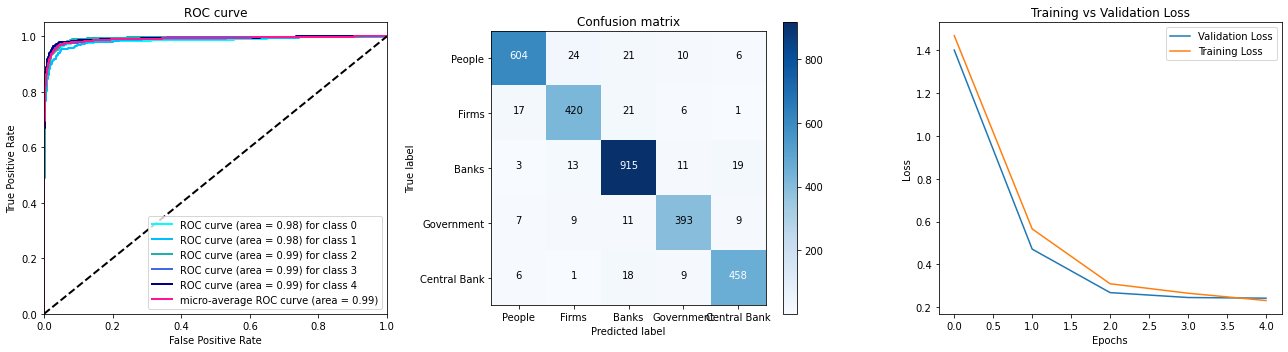

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model_name = 'BERT' # name for saving

# Train the model
model, tokenizer, val_loss_values, training_loss_values = train_model(model, tokenizer, X_train, y_train, X_val, y_val, batch_size = 32, epochs=5, learning_rate= 4e-6, gradient_accumulation_steps=2, modelName=path+'/result/'+model_name)

# Test the model
y_true, y_pred, y_pred_prob = test_model(model, tokenizer, X_val, y_val)

# Print the classification report
# plot/ show evaluation
show_evaluation_results(y_true, y_pred, y_pred_prob, val_loss_values, training_loss_values)

## 2. Apply Results to Test Data

Predict for Test Data using BERT Model and Save results to Dataframe

In [ ]:
#Load test data here
Predicted_Auidence = predict_audience(model, tokenizer, FED_data_large['Parsed_Text'].values)
FED_data_large["Predicted Auidence (BERT)"] = Predicted_Auidence[0]
FED_data_large['Audience (Probabilities) (BERT)'] =  [Predicted_Auidence[1][i, :] for i in range(len(FED_data_large))]
FED_data_large.head(5)

# G - 2) XLNet

The XLNet model was proposed in [`XLNet: Generalized Autoregressive Pretraining for Language Understanding`](https://arxiv.org/abs/1906.08237) by Zhilin Yang, Zihang Dai, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, Quoc V. Le. XLnet is an extension of the Transformer-XL model pre-trained using an autoregressive method to learn bidirectional contexts by maximizing the expected likelihood over all permutations of the input sequence factorization order.

For a more powerful but slower working model, change `xlnet-base-cased` to `xlnet-large-cased`.

## 1. Training Loop and Evaluation

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
0,1.377800,1.273010,0.446879,0.260132,0.632089,0.320483,26.171800,115.086000
1,0.431400,0.338143,0.892430,0.885136,0.894838,0.877439,26.165500,115.113000
2,0.291700,0.267140,0.920651,0.917669,0.922498,0.913899,26.100600,115.400000
3,0.307200,0.245933,0.924967,0.922196,0.924853,0.919796,26.169800,115.094000
4,0.247400,0.245493,0.927291,0.924792,0.929539,0.920660,26.204300,114.943000


Classification Report:
              precision    recall  f1-score   support

      People       0.95      0.91      0.93       665
       Firms       0.90      0.89      0.90       465
       Banks       0.91      0.96      0.94       961
  Government       0.95      0.91      0.93       429
Central Bank       0.93      0.93      0.93       492

    accuracy                           0.93      3012
   macro avg       0.93      0.92      0.92      3012
weighted avg       0.93      0.93      0.93      3012



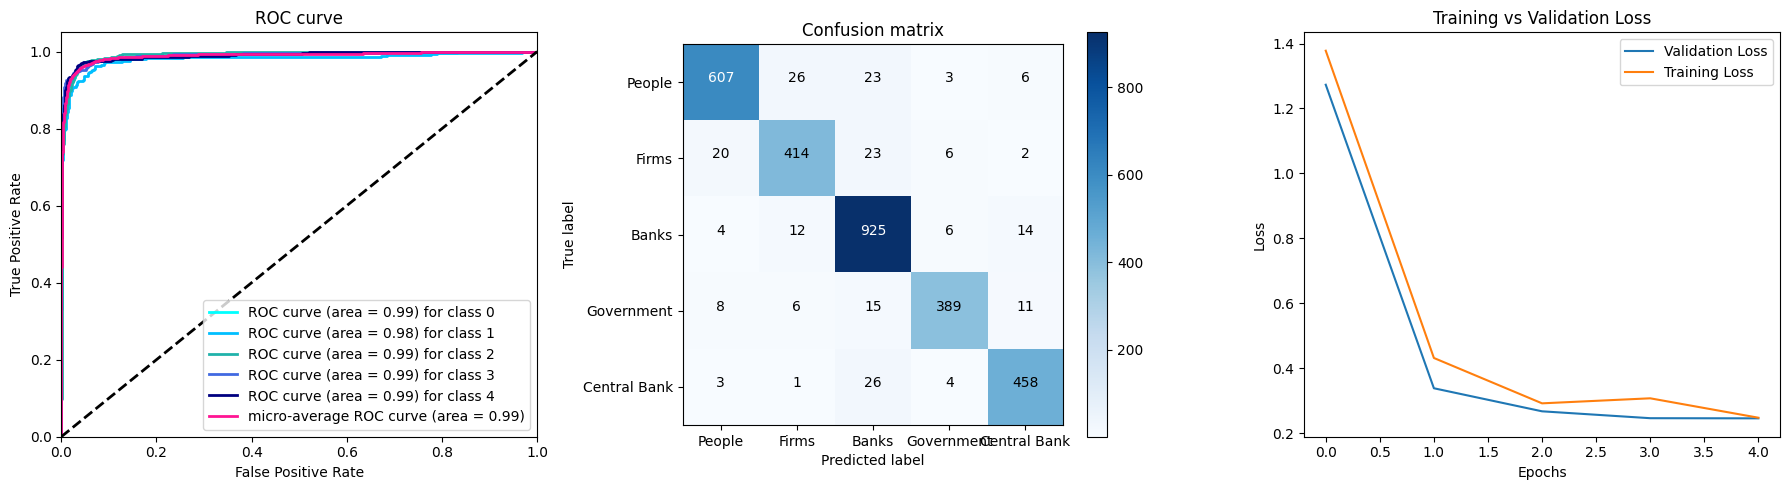

In [ ]:
from transformers import XLNetForSequenceClassification, XLNetTokenizer

# Load the pre-trained BERT model
model_xlnet = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=5)

# Load pre-trained XLNet model
tokenizer_xlnet = XLNetTokenizer.from_pretrained('xlnet-base-cased')

model_name = 'XLNet' # name for saving

# Train the model
model_xlnet, tokenizer_xlnet, val_loss_values, training_loss_values = train_model(model_xlnet, tokenizer_xlnet, X_train, y_train, X_val, y_val, epochs=5, learning_rate = 4e-6, batch_size= 32, gradient_accumulation_steps = 2, modelName=path+'/result/'+model_name)

# Test the model
y_true, y_pred, y_pred_prob = test_model(model_xlnet, tokenizer_xlnet, X_val, y_val)

# Print the classification report
# plot/ show evaluation
show_evaluation_results(y_true, y_pred, y_pred_prob, val_loss_values, training_loss_values)

## 2. Apply Results to Test Data

Predict for Test Data using XLNet Model and Save results to Dataframe

In [ ]:
Predicted_Auidence = predict_audience(model_xlnet, tokenizer_xlnet, FED_data_large['Parsed_Text'].values)
FED_data_large["Predicted Auidence (XLNet)"] = Predicted_Auidence[0]
FED_data_large['Audience (Probabilities) (XLNet)'] =  [Predicted_Auidence[1][i, :] for i in range(len(FED_data_large))]
FED_data_large.head(5)

# J - 4) RoBERTa

The RoBERTa model is a BERT-based model that was proposed in [`RoBERTa: A Robustly Optimized BERT Pretraining Approach`](https://arxiv.org/abs/1907.11692) by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov. It is based on Google’s BERT model released in 2018. It modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

## 1. Training Loop and Evalutation

To use a more powerful model change `roberta-base` to `roberta-large` in following code.

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
0,1.609600,1.597399,0.426627,0.293420,0.257184,0.380978,9.674900,311.323000
1,0.569200,0.399411,0.907371,0.902194,0.908528,0.897515,9.672400,311.403000
2,0.263100,0.259279,0.922643,0.919128,0.923607,0.915549,9.672000,311.415000
3,0.247300,0.224889,0.927623,0.924346,0.924437,0.924507,9.671400,311.435000
4,0.211300,0.218622,0.931607,0.928581,0.928681,0.929294,9.686300,310.953000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

      People       0.96      0.90      0.93       665
       Firms       0.87      0.92      0.90       465
       Banks       0.94      0.96      0.95       961
  Government       0.95      0.93      0.94       429
Central Bank       0.92      0.95      0.93       492

    accuracy                           0.93      3012
   macro avg       0.93      0.93      0.93      3012
weighted avg       0.93      0.93      0.93      3012



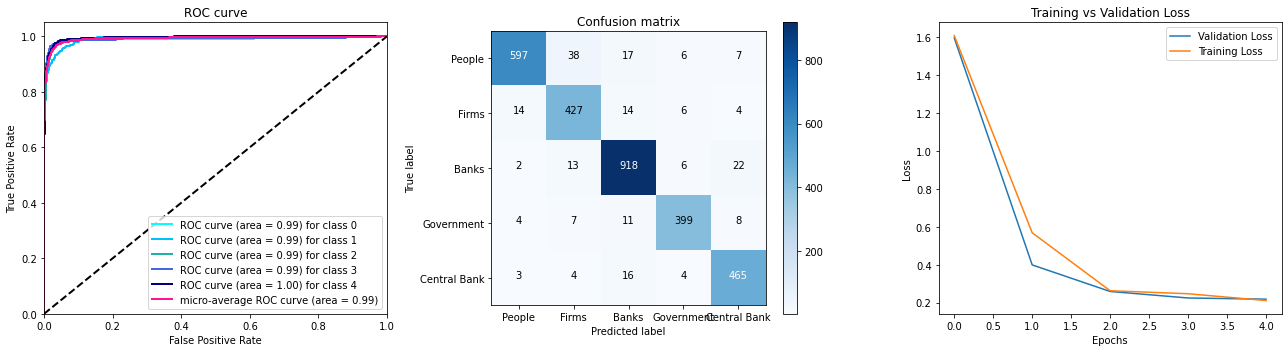

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Load the pre-trained tokenizer and model
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
model_roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

model_name = 'RoBERTa' # name for saving

# Train the model
model_roberta, tokenizer_roberta, val_loss_values, training_loss_values = train_model(model_roberta, tokenizer_roberta, X_train, y_train, X_val, y_val, batch_size = 64, gradient_accumulation_steps = 2, learning_rate = 7e-6, epochs=5, modelName=path+'/result/'+model_name)

# Test the model
y_true, y_pred, y_pred_prob = test_model(model_roberta, tokenizer_roberta, X_val, y_val)

# Print the classification report
# plot/ show evaluation
show_evaluation_results(y_true, y_pred, y_pred_prob, val_loss_values, training_loss_values)

## 2. Apply Results to Test Data

Predict for Test Data using Roberta Model and Save results to Dataframe

In [ ]:
Predicted_Auidence = predict_audience(model_xlnet, tokenizer_xlnet, FED_data_large['Parsed_Text'].values)
FED_data_large["Predicted Auidence (RoBERTa)"] = Predicted_Auidence[0]
FED_data_large['Audience (Probabilities) (RoBERTa)'] =  [Predicted_Auidence[1][i, :] for i in range(len(FED_data_large))]
FED_data_large.head(5)